# Q1 — Baseline Analysis and Random Forest Regression (Console & Genre → Total Sales)

## Aim
This notebook investigates whether a game’s **console** and **genre** are informative predictors of its **total global sales**.

## Scope (filtered dataset)
To keep the analysis focused and comparable, we restrict the dataset to:
- Consoles: **PS4, XOne, PC**
- Genres: **Action, Sports, Role-Playing, Adventure**

## Approach
1. Load and clean the dataset (remove missing values)
2. Filter to the chosen consoles/genres
3. Compute **baseline mean sales** (simple, interpretable comparison)
4. Train a **Random Forest Regressor** using one-hot encoding
5. Predict which **console–genre combinations** are expected to sell best

In [20]:
import sys
from pathlib import Path

# Repo root is one level above Q1_folder
ROOT = Path().resolve().parent
sys.path.append(str(ROOT / "py"))

DATA_PATH = ROOT / "data" / "VideoGames_Sales.xlsx"

import seaborn as sns
sns.set(style="whitegrid")

from functions import (
    get_data,
    filter_ps4_xone_pc_and_selected_genres,
    baseline_means,
    encode_console_genre,
    train_and_evaluate_rf,
    top_console_genre_predictions
)

## 1) Load and inspect the data

We load the Excel file, keep only the three columns needed for this coursework question,
and remove rows containing missing values. This ensures the model is trained on complete examples.

In [21]:
df = get_data(DATA_PATH)

print("Dataset shape (after selecting columns + dropping NaNs):", df.shape)
df.head()

Dataset shape (after selecting columns + dropping NaNs): (18922, 3)


,console,genre,total_sales(mil)
0,PS3,Action,20.32
1,PS4,Action,19.39
2,PS2,Action,16.15
3,X360,Action,15.86
4,PS4,Shooter,15.09


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18922 entries, 0 to 18921
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   console           18922 non-null  object 
 1   genre             18922 non-null  object 
 2   total_sales(mil)  18922 non-null  float64
dtypes: float64(1), object(2)
memory usage: 591.3+ KB


## 2) Filter to the chosen consoles and genres

The coursework question focuses on whether console/genre affect sales.  
To reduce noise and keep comparisons meaningful, we filter to three consoles (PS4, XOne, PC)
and four genres (Action, Sports, Role-Playing, Adventure).

In [23]:
F_DataFrame, masks = filter_ps4_xone_pc_and_selected_genres(df)

## 3) Baseline: mean sales by category

Before using machine learning, we compute baseline averages:
- Mean sales by **console**
- Mean sales by **genre**
- Mean sales by **console × genre**

This gives a simple reference point to compare with the Random Forest predictions later.

In [24]:
mean_console, mean_genre, mean_console_genre = baseline_means(df, masks)

print("Mean total sales by console:")
display(mean_console)

print("\nMean total sales by genre:")
display(mean_genre)

print("\nMean total sales by console × genre:")
display(mean_console_genre.head(12))

Mean total sales by console:


console
PS4     0.594626
XOne    0.513282
PC      0.108327
Name: total_sales(mil), dtype: float64


Mean total sales by genre:


genre
Sports          0.457262
Action          0.396580
Role-Playing    0.286251
Adventure       0.171891
Name: total_sales(mil), dtype: float64


Mean total sales by console × genre:


,console,genre,total_sales(mil)
7,PS4,Sports,1.327317
11,XOne,Sports,0.717647
4,PS4,Action,0.510552
8,XOne,Action,0.457647
10,XOne,Role-Playing,0.428235
6,PS4,Role-Playing,0.383689
5,PS4,Adventure,0.163973
2,PC,Role-Playing,0.125041
9,XOne,Adventure,0.103714
3,PC,Sports,0.097476


## 4) Train a Random Forest Regressor

### Why Random Forest?
A Random Forest is a strong baseline model for tabular data because it:
- handles non-linear relationships,
- is robust to noise,
- works well with one-hot encoded categorical features,
- and can outperform simple linear models without heavy tuning.

### Feature representation
Console and genre are categorical, so we use **one-hot encoding** to create numeric input features.

In [25]:
x_encoded, y = encode_console_genre(F_DataFrame)

model, results = train_and_evaluate_rf(x_encoded, y)
results

,metric,value
0,r2,-0.022511
1,rmse,0.566930


### Interpreting the metrics
- **R²** measures how much of the variance in sales is explained by the model (higher is better).
- **RMSE** measures the typical prediction error in the same units as the target variable (lower is better).

Because we only use two features (console + genre), we should not expect perfect performance.
Sales are influenced by many other factors (marketing, franchise popularity, release timing, reviews, etc.).

## 5) Predict the best console–genre combinations

Finally, we create all possible console–genre combinations present in the filtered data,
encode them in the same feature space as training, and predict expected total sales.

In [26]:
top_combos = top_console_genre_predictions(model, F_DataFrame, x_encoded.columns, top_n=12)
top_combos

,console,genre,predicted_total_sales(mil)
1,PS4,Sports,1.528517
5,XOne,Sports,0.766120
0,PS4,Action,0.523920
6,XOne,Role-Playing,0.503427
4,XOne,Action,0.477984
2,PS4,Role-Playing,0.421339
3,PS4,Adventure,0.185694
10,PC,Role-Playing,0.143484
7,XOne,Adventure,0.091903
8,PC,Action,0.077664


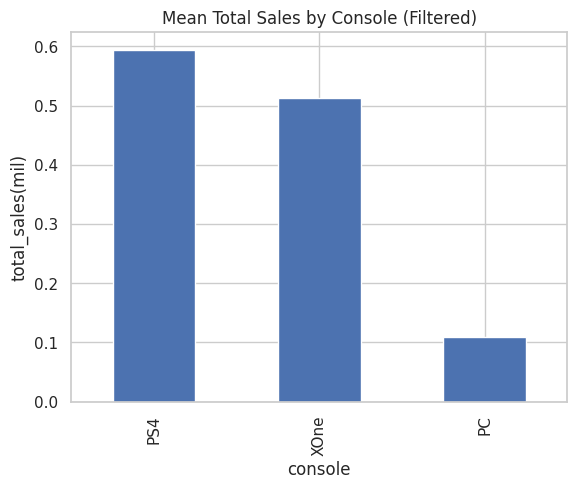

In [27]:
import matplotlib.pyplot as plt

mean_console.plot(kind="bar")
plt.title("Mean Total Sales by Console (Filtered)")
plt.ylabel("total_sales(mil)")
plt.show()

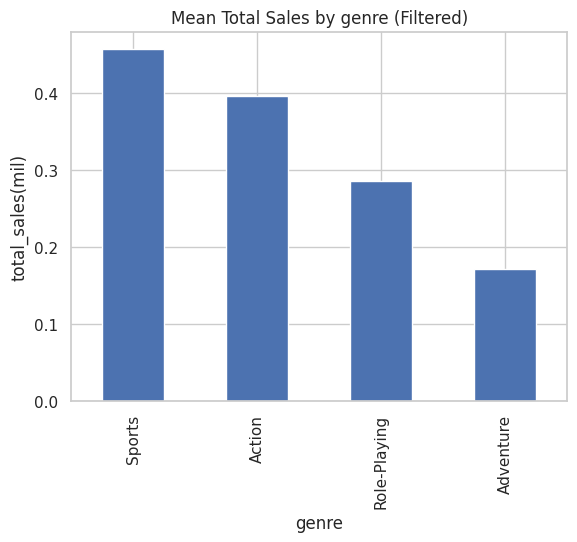

In [29]:
mean_genre.plot(kind="bar")
plt.title("Mean Total Sales by genre (Filtered)")
plt.ylabel("total_sales(mil)")
plt.show()

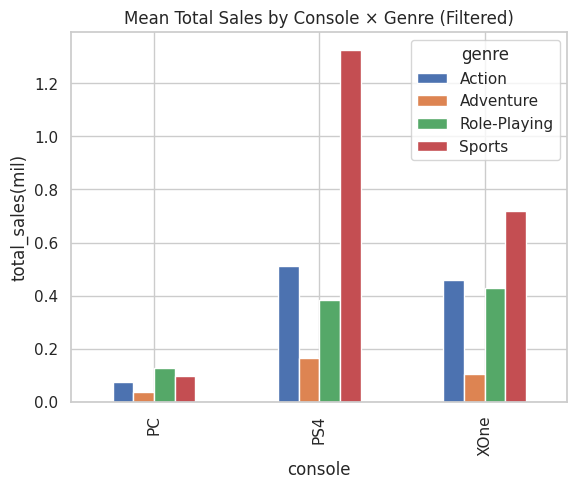

In [28]:
pivot = mean_console_genre.pivot(index="console", columns="genre", values="total_sales(mil)")
pivot.plot(kind="bar")
plt.title("Mean Total Sales by Console × Genre (Filtered)")
plt.ylabel("total_sales(mil)")
plt.show()

## Conclusion (Q1)

- Baseline means provide an interpretable first look at which consoles and genres tend to sell best on average.
- A Random Forest trained only on **console** and **genre** can capture some predictive structure,
  but performance is limited because many important sales drivers are not included.
- The top predicted console–genre combinations provide an ML-based estimate of what might be expected to sell best,
  which can be compared against the baseline mean rankings.

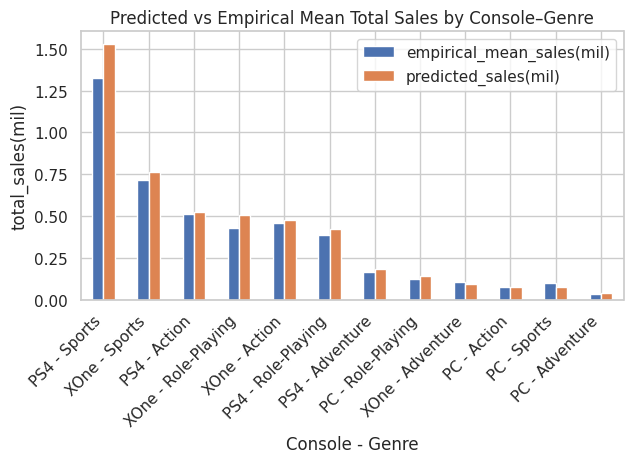

,console,genre,empirical_mean_sales(mil),predicted_sales(mil),combo
0,PS4,Sports,1.327317,1.528517,PS4 - Sports
1,XOne,Sports,0.717647,0.766120,XOne - Sports
2,PS4,Action,0.510552,0.523920,PS4 - Action
3,XOne,Role-Playing,0.428235,0.503427,XOne - Role-Playing
4,XOne,Action,0.457647,0.477984,XOne - Action
5,PS4,Role-Playing,0.383689,0.421339,PS4 - Role-Playing
6,PS4,Adventure,0.163973,0.185694,PS4 - Adventure
7,PC,Role-Playing,0.125041,0.143484,PC - Role-Playing
8,XOne,Adventure,0.103714,0.091903,XOne - Adventure
9,PC,Action,0.073194,0.077664,PC - Action


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Make sure columns line up
empirical = mean_console_genre.rename(columns={"total_sales(mil)": "empirical_mean_sales(mil)"})

predicted = top_combos.rename(columns={"predicted_total_sales(mil)": "predicted_sales(mil)"}).copy()

# 2) Merge on console + genre (inner keeps only matching combinations)
compare = pd.merge(empirical, predicted[["console", "genre", "predicted_sales(mil)"]],
                   on=["console", "genre"], how="inner")

# 3) Create a readable label for plotting
compare["combo"] = compare["console"] + " - " + compare["genre"]

# 4) Sort by predicted (or empirical) so plot is easier to read
compare = compare.sort_values("predicted_sales(mil)", ascending=False)

# 5) Plot side-by-side bars
ax = compare.set_index("combo")[["empirical_mean_sales(mil)", "predicted_sales(mil)"]].plot(kind="bar")

plt.title("Predicted vs Empirical Mean Total Sales by Console–Genre")
plt.ylabel("total_sales(mil)")
plt.xlabel("Console - Genre")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Optional: show the merged table too
compare.reset_index(drop=True)
